In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.data import AUTOTUNE
import sentiment


DATASET_DIR = './goemotions/data-v2/'

In [2]:
classes = sentiment.load_classes(DATASET_DIR)
classes

['admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise',
 'neutral']

Random seed: 1681944339


D:\sentiment-analysis\sentiment.py:236: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  class_mask = (train_df['labels'].str.contains(r'(^|,)' + label +
D:\sentiment-analysis\sentiment.py:564: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classes, rotation=45, ha='right')


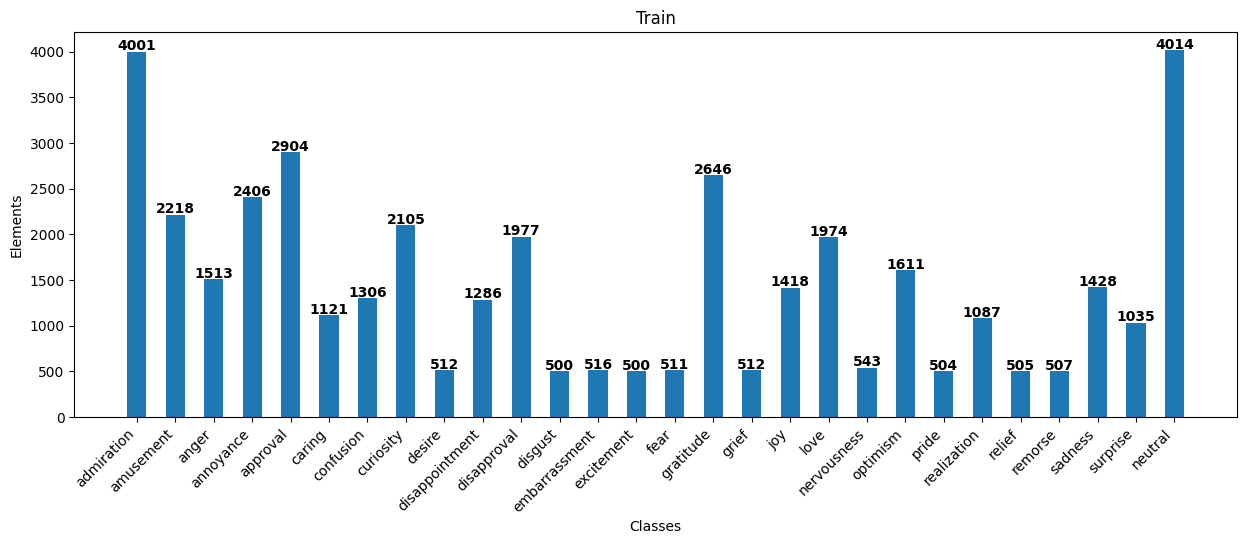

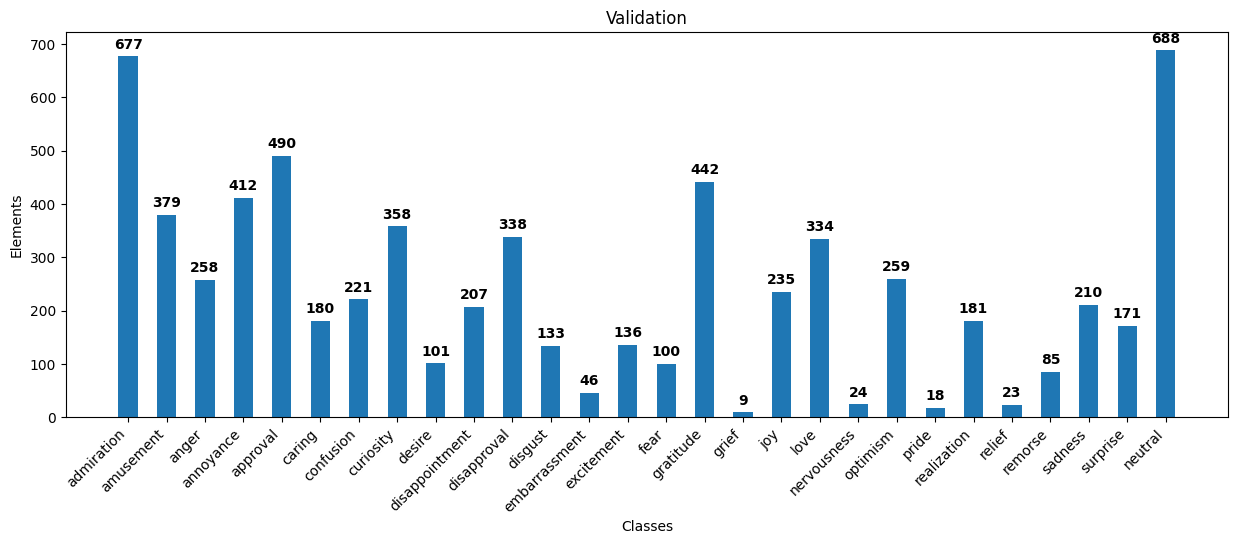

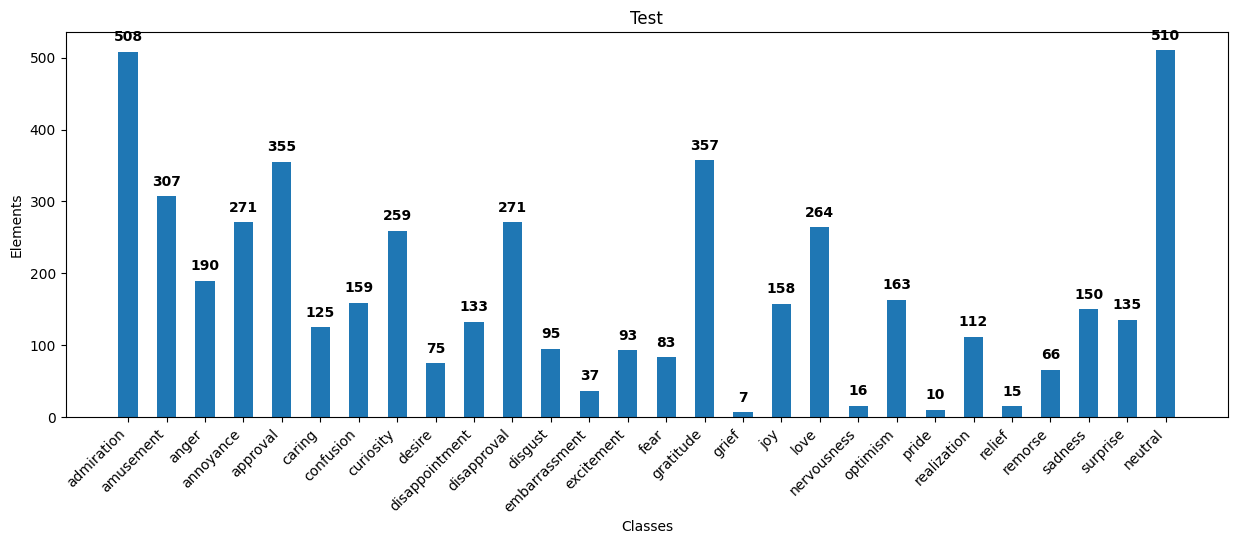

CPU times: total: 4.7 s
Wall time: 4.8 s


In [3]:
%%time
BATCH_SIZE = 64


train_df, val_df, test_df = sentiment.make_dataframes(DATASET_DIR,
                                                      fraction=0.85,
                                                      random=1681944339,
                                                      split_by_class=True,
                                                      clean=True,
                                                      cut_neutral=True,
                                                      test_only_singles=True,
                                                      oversample_low=True,
                                                      low_threshold=500)
dataframes = {'Train': train_df, 'Validation': val_df, 'Test': test_df}
for title, df in dataframes.items():
    sentiment.plot_class_distr(df, classes, title)

In [4]:
from nltk import (word_tokenize, pos_tag)
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# https://stackoverflow.com/questions/15388831/what-are-all-possible-pos-tags-of-nltk
MEANINGFUL_TAGS = ('JJ', 'JJR', 'JJS', 'NN', 'NNP', 'NNS', 'PDT', 'RB', 'RBR', 'RBS', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ')
WNL = WordNetLemmatizer()


def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

def select_tags(tagged):
    words = []
    for (word, tag) in tagged:
        if tag not in MEANINGFUL_TAGS:
            continue
        if len(word) < 3:
            continue
        if "'" in word:
            continue
        wordnet_pos = get_wordnet_pos(tag)
        if wordnet_pos:
            word = WNL.lemmatize(word, wordnet_pos)
        if len(word) < 3:
            continue
        words.append(word)
    return words


def retokenize(text):
    tokens = word_tokenize(text)
    tags = pos_tag(tokens)
    selected = select_tags(tags)
    if selected:
        return ' '.join(selected)
    else:
        return np.nan

In [5]:
%%time
for df in (train_df, val_df, test_df):
    df['text'] = df['text'].apply(retokenize)
    df.drop(df[df['text'].isna()].index, axis=0, inplace=True)

CPU times: total: 58.5 s
Wall time: 58.8 s


In [6]:
train_df.head()

,text,labels
0,recent russian behavior unacceptable doubt,"10,27"
1,chiropractic just scam anyway lot study show h...,"5,24"
2,glad have attendance day skip class impossible,17
3,sister put foot muddy end pond once think die ...,1
4,imagine have get service fault twice match point,7


In [7]:
train_ds = sentiment.make_ts_ds(train_df, classes, BATCH_SIZE, AUTOTUNE)
val_ds = sentiment.make_ts_ds(val_df, classes, BATCH_SIZE, AUTOTUNE)
test_ds = sentiment.make_ts_ds(test_df, classes, BATCH_SIZE, AUTOTUNE)

In [8]:
from tensorflow.keras.layers import TextVectorization

VOCAB_SIZE = 20_000


encoder = TextVectorization(max_tokens=VOCAB_SIZE,
                            standardize='lower_and_strip_punctuation',
                            split='whitespace',
                            pad_to_max_tokens=True,
                            output_mode='tf_idf')
encoder.adapt(train_ds.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['[UNK]', 'have', 'not', 'get', 'just', 'love', 'good', 'make',
       'think', 'people', 'really', 'know', 'thanks', 'see', 'lol',
       'look', 'say', 'thank', 'too', 'time'], dtype='<U73')

In [9]:
from tensorflow.keras.layers import (Dropout, Dense)
from tensorflow.keras import Sequential

classifier = Sequential([
    encoder,
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(len(classes), activation='sigmoid'),
])

In [10]:
from tensorflow.keras.losses import BinaryCrossentropy
from keras.optimizers import Adam

METRICS_THRESHOLD = 0.5
LEARNING_RATE = 1e-4


metrics = sentiment.create_metrics(classes, METRICS_THRESHOLD)
loss = BinaryCrossentropy()
classifier.compile(Adam(learning_rate=LEARNING_RATE), loss=loss, metrics=metrics)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping


EPOCHS = 100


hist = classifier.fit(x=train_ds, validation_data=val_ds,
                      validation_steps=30, epochs=EPOCHS,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
                     )

Epoch 1/100
503/503 [==============================] - 47s 79ms/step - loss: 0.3749 - precision@0.5/admiration: 0.1554 - recall@0.5/admiration: 0.0150 - precision@0.5/amusement: 0.0803 - recall@0.5/amusement: 0.0749 - precision@0.5/anger: 0.0536 - recall@0.5/anger: 0.1257 - precision@0.5/annoyance: 0.0797 - recall@0.5/annoyance: 0.0570 - precision@0.5/approval: 0.0905 - recall@0.5/approval: 0.0436 - precision@0.5/caring: 0.0359 - recall@0.5/caring: 0.0787 - precision@0.5/confusion: 0.0359 - recall@0.5/confusion: 0.0572 - precision@0.5/curiosity: 0.0779 - recall@0.5/curiosity: 0.0461 - precision@0.5/desire: 0.0197 - recall@0.5/desire: 0.0723 - precision@0.5/disappointment: 0.0360 - recall@0.5/disappointment: 0.0653 - precision@0.5/disapproval: 0.0611 - recall@0.5/disapproval: 0.0147 - precision@0.5/disgust: 0.0123 - recall@0.5/disgust: 0.0200 - precision@0.5/embarrassment: 0.0210 - recall@0.5/embarrassment: 0.0524 - precision@0.5/excitement: 0.0209 - recall@0.5/excitement: 0.1434 - prec

In [12]:
eval_metrics = classifier.evaluate(x=test_ds, return_dict=True)
sentiment.print_metrics(eval_metrics)

77/77 [==============================] - 2s 19ms/step - loss: 0.1019 - precision@0.5/admiration: 0.7075 - recall@0.5/admiration: 0.4665 - precision@0.5/amusement: 0.8551 - recall@0.5/amusement: 0.5765 - precision@0.5/anger: 0.5821 - recall@0.5/anger: 0.2053 - precision@0.5/annoyance: 0.3600 - recall@0.5/annoyance: 0.0996 - precision@0.5/approval: 0.4018 - recall@0.5/approval: 0.1268 - precision@0.5/caring: 0.4688 - recall@0.5/caring: 0.1210 - precision@0.5/confusion: 0.6061 - recall@0.5/confusion: 0.1274 - precision@0.5/curiosity: 0.4524 - recall@0.5/curiosity: 0.0751 - precision@0.5/desire: 0.7059 - recall@0.5/desire: 0.1600 - precision@0.5/disappointment: 0.4375 - recall@0.5/disappointment: 0.0526 - precision@0.5/disapproval: 0.4250 - recall@0.5/disapproval: 0.0632 - precision@0.5/disgust: 0.8000 - recall@0.5/disgust: 0.1684 - precision@0.5/embarrassment: 0.5833 - recall@0.5/embarrassment: 0.1892 - precision@0.5/excitement: 0.8750 - recall@0.5/excitement: 0.0761 - precision@0.5/fear:

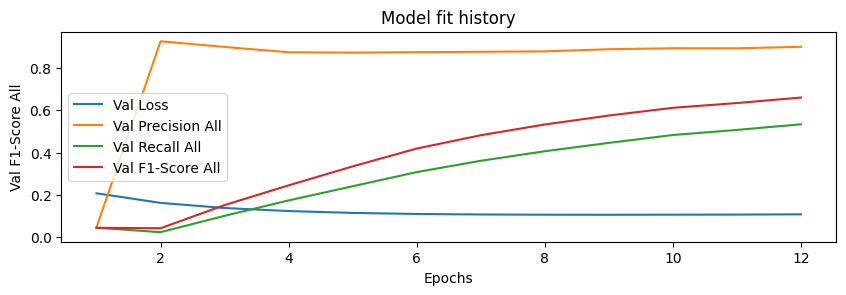

In [13]:
stats = hist.history
stats_graps = {
    'Val Loss': stats['val_loss'],
    'Val Precision All': stats['precision@0.5/all'],
    'Val Recall All': stats['recall@0.5/all'],
    'Val F1-Score All': stats['f1_score@0.5/all']
}
sentiment.plot_history(stats_graps)

In [14]:
sentiment.score_test_precision(test_ds, classifier)

0.67543423

In [15]:
sentiments = sentiment.load_sentiments(DATASET_DIR)
sentiment_map = sentiment.map_sentiments(classes, sentiments)
sentiment.score_test_precision(test_ds, classifier, 0.5, sentiment_map)

0.8113788

In [16]:
sentiment.test_examples(classifier, classes)

WARNING! Model not sure (all predictions less than 0.5)
I am feeling great today!: admiration 👏
WARNING! Model not sure (all predictions less than 0.5)
The weather is so good: neutral ⚪
WARNING! Model not sure (all predictions less than 0.5)
I have performed well at the university: neutral ⚪
WARNING! Model not sure (all predictions less than 0.5)
The war has started: neutral ⚪
WARNING! Model not sure (all predictions less than 0.5)
He is desperate in this cruel world: anger 😡
WARNING! Model not sure (all predictions less than 0.5)
I love the feeling when my girlfriend hugs me: neutral ⚪
WARNING! Model not sure (all predictions less than 0.5)
I hate monday mornings: anger 😡
Look forward to seeing you today: admiration 👏
WARNING! Model not sure (all predictions less than 0.5)
Merry Christmas! I told Santa you were good this year and asked him to bring you a year full of joy and pleasure : neutral ⚪
brilliant! Such a detailed review, it was a pleasure, thank you! Guys, make sure you find 

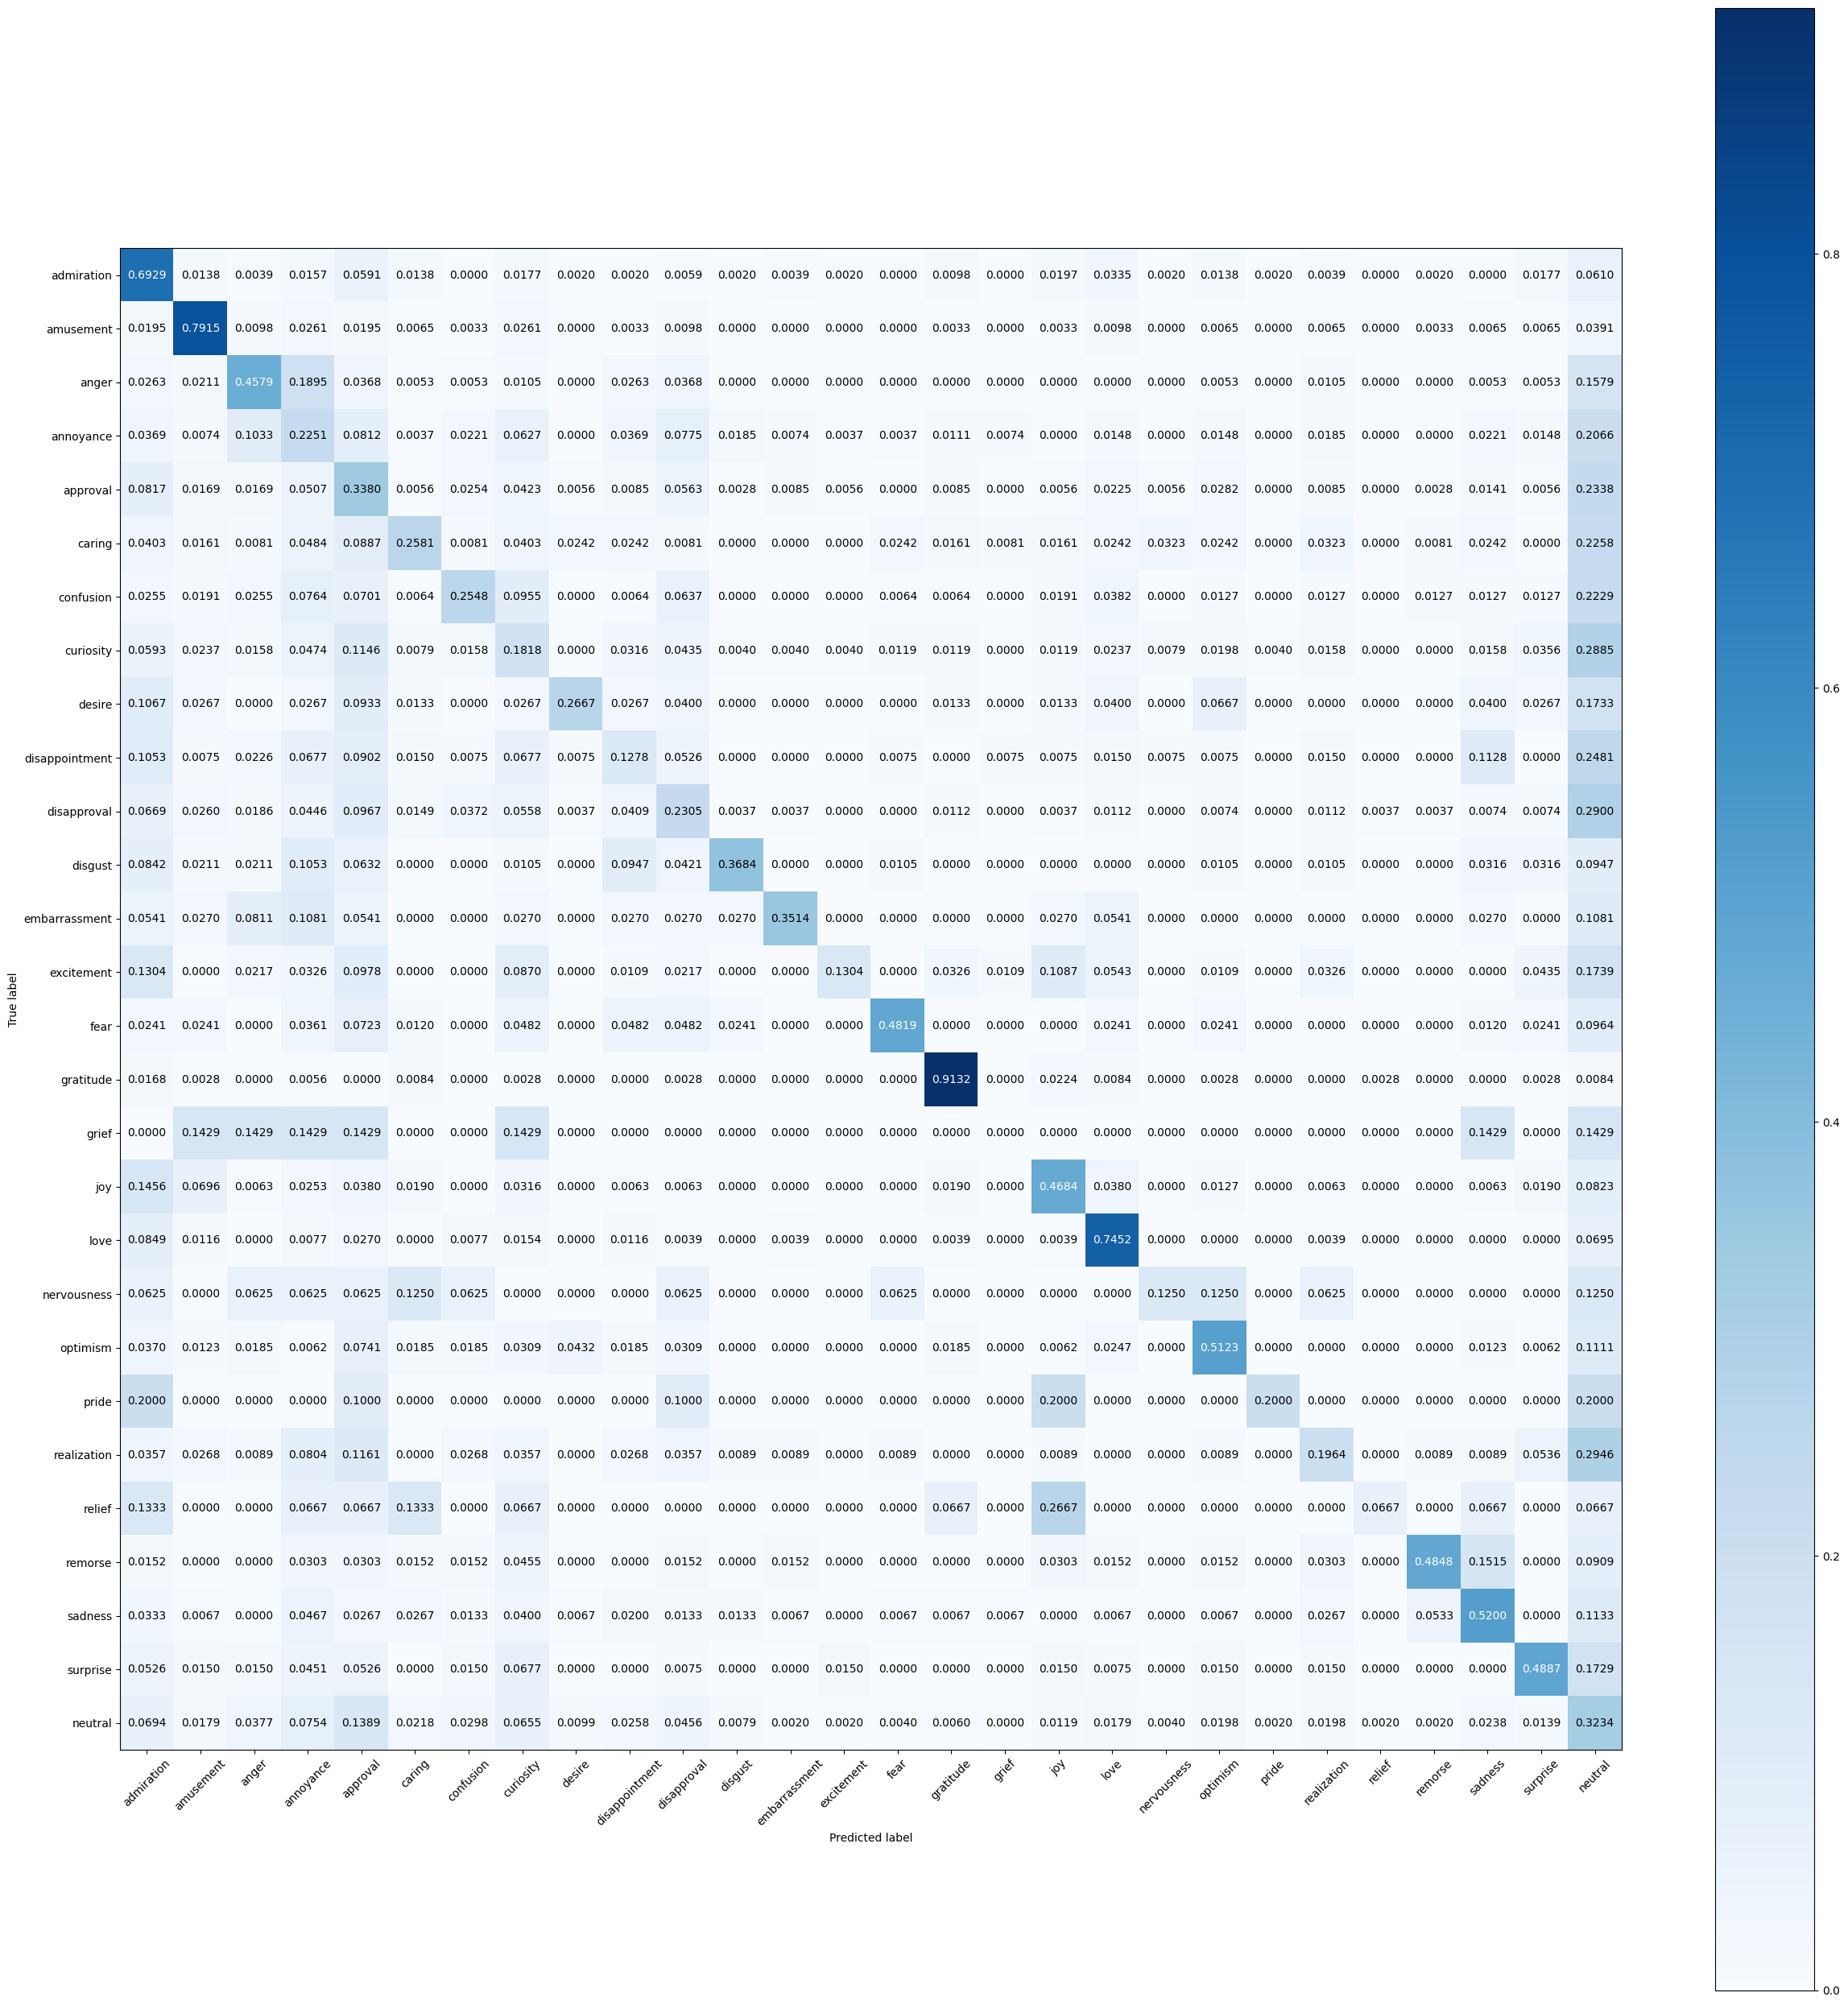

In [17]:
sentiment.plot_conf_mtrx_all(classifier, test_ds, classes)

2/2 [==============================] - 0s 6ms/step


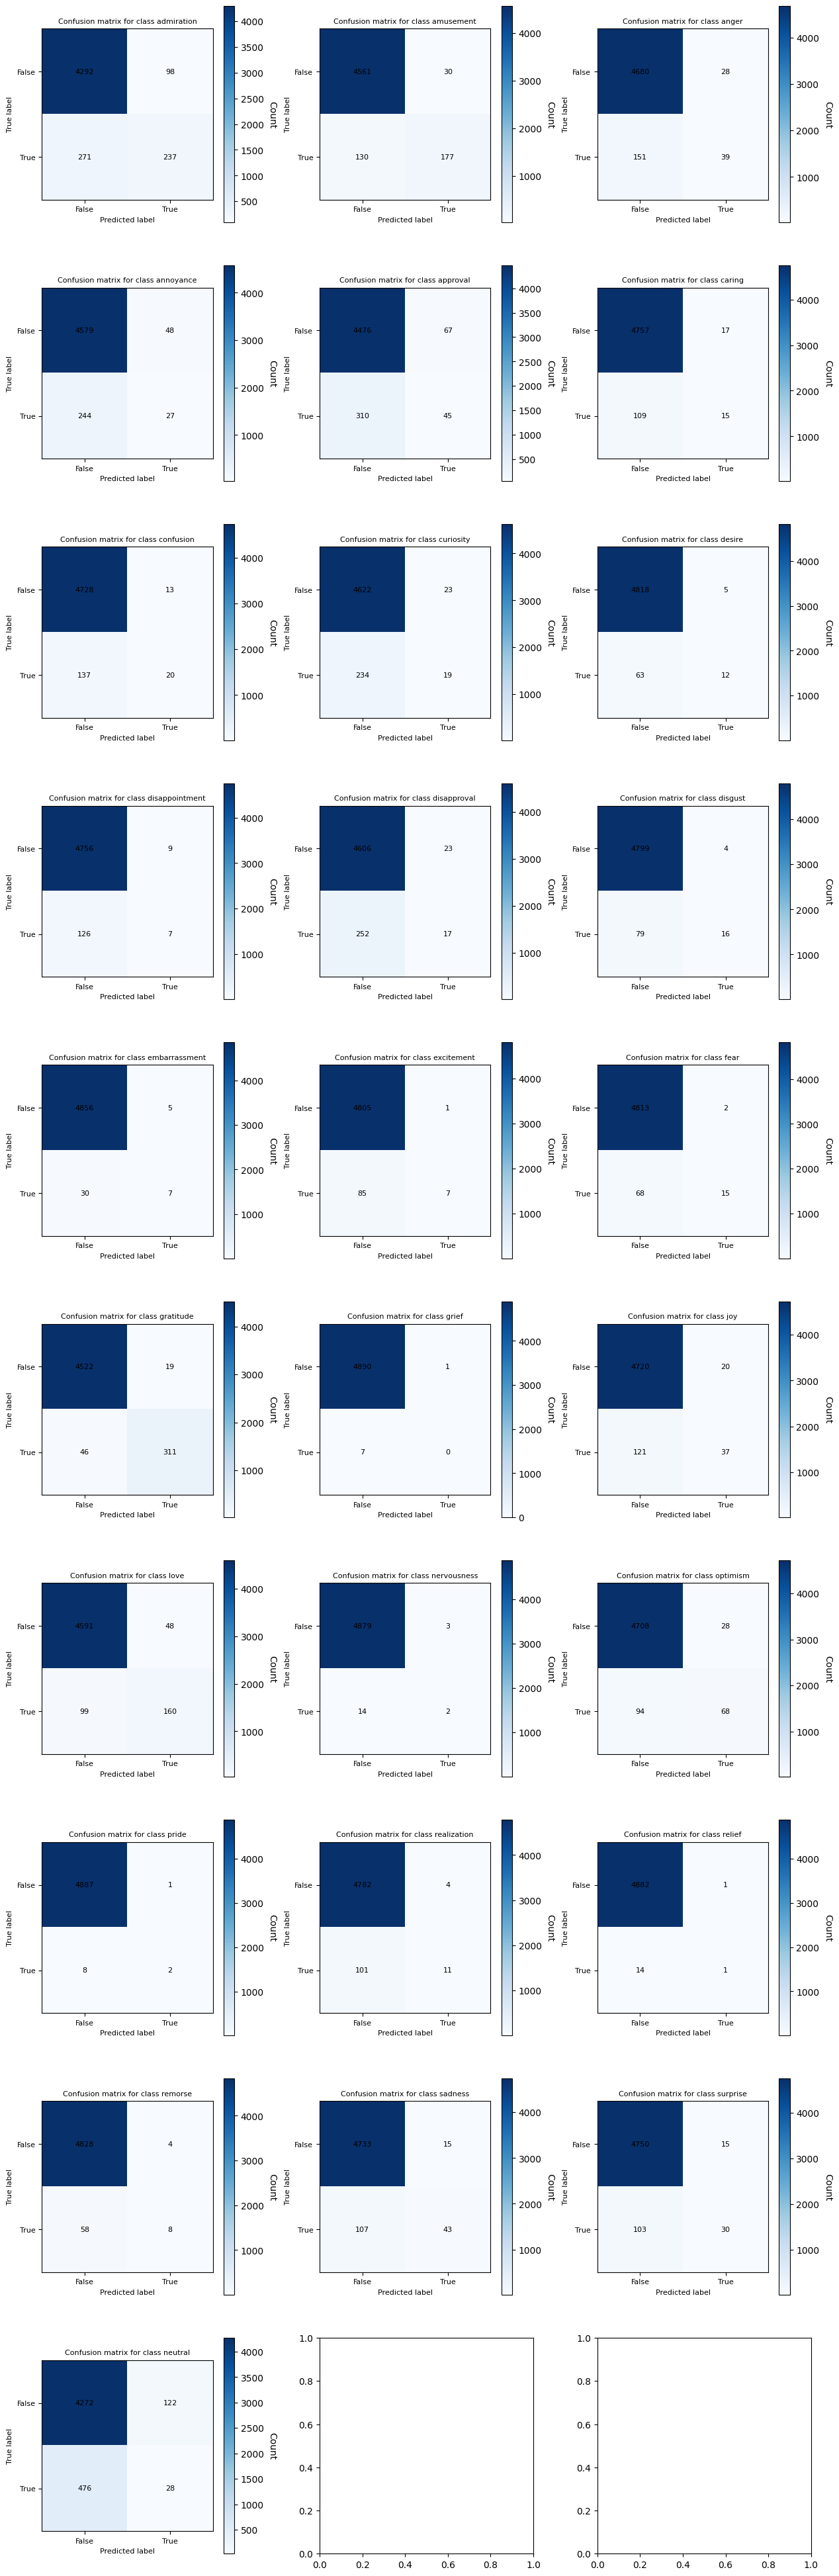

In [19]:
sentiment.plot_conf_mtrx_per_class(classifier, test_ds, classes)

In [20]:
classifier.save('./models/mlp-nltk', include_optimizer=False)

INFO:tensorflow:Assets written to: ./models/mlp-nltk\assets
